


### Not Enough DATA


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline


### Let's create some datapoints. Please note the number of majority and minority classes.

In [2]:
num_majority_class=1000
num_minority_class=150

majority_class_flag=-1.0
minority_class_flag=1.0

def generate_data(num_majority_class,num_minority_class):
    np.random.seed(42)
    # multiply by 2 to have higher variance!
    x1=np.random.standard_normal(num_majority_class)*2
    x2=np.random.standard_normal(num_majority_class)*2
    xdata=pd.DataFrame(data=[x1,x2]).transpose()
    xdata=xdata.rename(index=str, columns={0: "x1", 1: "x2"})
    xdata['category']=majority_class_flag
    xdata.head()

    # multiply by a number under 1 to have less variance!
    # multiply by a number above 1 to have more variance!
    x1=np.random.standard_normal(num_minority_class)*1.0+2.5
    x2=np.random.standard_normal(num_minority_class)*1.0+2.5
    y2=np.full(num_minority_class,minority_class_flag)
    cat2=pd.DataFrame(data=[x1,x2,y2]).transpose()
    cat2=cat2.rename(index=str, columns={0: "x1", 1: "x2", 2:"category"})
    xdata=xdata.append(cat2)
    xdata=xdata.reset_index(drop=True)
    return xdata

xdata=generate_data(num_majority_class,num_minority_class)


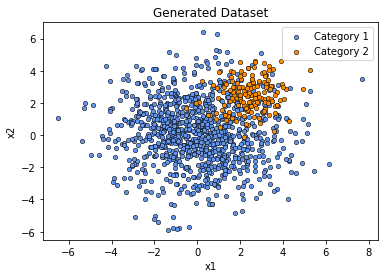

In [3]:

def plot_data_points(plotdatax):
    ax = plotdatax[plotdatax['category']==majority_class_flag].plot.scatter(x="x1",y="x2", color='cornflowerblue',edgecolor='black', linewidth='0.5',marker="o",s=20, label='Category 1');
    plotdatax[plotdatax['category']==minority_class_flag].plot.scatter(x="x1",y="x2", color='darkorange',edgecolor='black', linewidth='0.5', label='Category 2',s=20, ax=ax);
    return ax
plot_data_points(xdata)
plt.title("Generated Dataset")
plt.show()

### Create Train and Eval set

In [4]:

data=xdata.copy()
y=data.pop('category')
X=data
x_train, x_eval, y_train, y_eval = train_test_split(X,y,test_size=0.3, random_state = 42)
    


## Let's solve this first with Tensorflow and Linear SVM
Lets create the loss function with tensorflow graph so later we can modify it. 


### Create Placeholders and Variables

In [5]:
import tensorflow as tf
tf.reset_default_graph()
ph_xdata = tf.placeholder(shape=[None,2],dtype=tf.float32)
ph_ytrue = tf.placeholder(shape=[None,1],dtype=tf.float32)
ph_weights= tf.placeholder(shape=[None,1],dtype=tf.float32)

#let's set some random init values
W = tf.get_variable("W", dtype=tf.float32,initializer=tf.constant([[23.],[ 42.]]))
b = tf.get_variable("b", dtype=tf.float32,initializer=tf.constant([[5.]]))


### Create Loss function

SVM uses the Hinge loss, you may remember the Hinge loss is:<br/>
<img src="svm_loss.png"
     alt="svm_loss_info"
/>
<br/>

where<br/>

<img src="svm_loss_info.png"
     alt="svm_loss_info"
     /><br/>

Let's implement this:

In [6]:

w_norm=tf.square(tf.norm(W))
alpha=tf.constant([0.1])

model_output=tf.subtract(tf.matmul(ph_xdata,W),b)
substract_term=tf.subtract(1.0,tf.multiply(model_output,ph_ytrue))

class_term=tf.reduce_mean(tf.maximum(0.0,substract_term))
hinge_loss_svm=tf.add(class_term,tf.multiply(alpha,w_norm))



In [7]:

def train(loss_candidate,x_train,y_train,y_weights=None):

    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train_step = optimizer.minimize(loss_candidate)
    # The init is done by us, therefore no init needed.
    #init = tf.global_variables_initializer()
    with tf.Session() as sess:

        #sess.run(init)
        sess.run(W.initializer)
        sess.run(b.initializer)

        epochs = 10000
        loss_vec=[]
        for i in range(epochs):
            if(y_weights is None):
                sess.run(train_step,feed_dict={ph_xdata : x_train,ph_ytrue:np.transpose([y_train]) })
                temp_loss=sess.run(loss_candidate,feed_dict={ph_xdata : x_train,ph_ytrue:np.transpose([y_train])})
            else:
                sess.run(train_step,feed_dict={ph_xdata : x_train,ph_ytrue:np.transpose([y_train]),ph_weights:y_weights })
                temp_loss=sess.run(loss_candidate,feed_dict={ph_xdata : x_train,ph_ytrue:np.transpose([y_train]),ph_weights:y_weights })
            
            loss_vec.append(temp_loss)
            if(i%500==0):
                # Fetch Back Results
                [[a1],[a2]] = sess.run(W)
                [[b1]]  = sess.run(b)
                temp_slope=-a2/a1
                temp_intercept=b1/a1
                print("loss:",temp_loss,"slope:",temp_slope,"intercept:",temp_intercept,"W",a1,a2,"b",b1)

        # Fetch Back Results
        [[w1],[w2]] = sess.run(W)
        [[b1]]  = sess.run(b)


    final_slope=-w2/w1
    final_intercept=b1/w1

    print("slope:",final_slope)
    print("intercept:",final_intercept)
    return final_slope,final_intercept
    
    
final_slope,final_intercept=train(hinge_loss_svm,x_train,y_train)

loss: [260.11066] slope: -1.8260081 intercept: 0.21803677 W 22.951397 41.909435 b 5.0042486
loss: [31.938393] slope: -1.7509825 intercept: 0.9199775 W 7.618658 13.3401375 b 7.008994
loss: [2.0932918] slope: -1.5594333 intercept: 4.082137 W 2.0510058 3.198407 b 8.372487
loss: [0.76287055] slope: -1.1315205 intercept: 6.6671176 W 1.224024 1.3850083 b 8.160712
loss: [0.6973049] slope: -0.96451586 intercept: 6.1039863 W 1.2486619 1.2043542 b 7.6218147
loss: [0.64072025] slope: -0.904842 intercept: 5.8400416 W 1.2160155 1.1003019 b 7.1015806
loss: [0.5883222] slope: -0.8745764 intercept: 5.6153407 W 1.1748735 1.0275166 b 6.597315
loss: [0.5408125] slope: -0.86458653 intercept: 5.4853415 W 1.1153169 0.96428794 b 6.117894
loss: [0.4983793] slope: -0.87088543 intercept: 5.472584 W 1.0358496 0.9021063 b 5.6687737
loss: [0.4603594] slope: -0.85783887 intercept: 5.35864 W 0.97814196 0.8390882 b 5.241511
loss: [0.4260499] slope: -0.8431512 intercept: 5.207629 W 0.92834634 0.78273636 b 4.8344836
lo

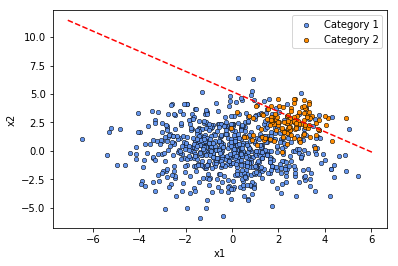

In [8]:
def abline(ax,slope, intercept):
    """Plot a line from slope and intercept"""
    axes = ax#plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',color='r')
    
def show_decision_boundary(final_slope,final_intercept):
    plotdatax=x_train.copy()
    plotdatax['category']=y_train

    ax=plot_data_points(plotdatax)
    abline(ax,final_slope,final_intercept)
    plt.show()

show_decision_boundary(final_slope,final_intercept)

In [9]:
def gen_weights(x,weight):
    if x==minority_class_flag:
        return weight
    else:
        return 1.0
generated_weights=y_train.apply(lambda x:gen_weights(x,6.0))
y_weights=np.transpose([generated_weights])


In [11]:

weighted_class_term=tf.reduce_mean(tf.maximum(0.0,tf.multiply(ph_weights,substract_term)))
weighted_loss_svm=tf.add(weighted_class_term,tf.multiply(alpha,w_norm))


In [ ]:
final_slope,final_intercept=train(weighted_loss_svm,x_train,y_train,y_weights)

In [ ]:
show_decision_boundary(final_slope,final_intercept)